In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

data_src = '../data/source/'
data_clean = '../data/clean/'
data_secondary = '../data/secondary/'
df = pd.read_csv(data_src+"train.csv") 
cat = pd.read_json(data_src+'categories.json')

def gen_barchart(categories):
    categories_map = {}
    for category in categories:
        if category not in categories_map:
            categories_map[category]=0
        categories_map[category]=categories_map[category] + 1

    keys = categories_map.keys()
    value = []
    for i in range(0, len(keys)):
         value.append(categories_map[i])

    plt.bar(keys, value, label='keys')
    plt.xlabel('category index')
    plt.ylabel('popln')
    plt.show()
    


In [2]:
recont_feature_const = {
    'group':{
        'go_in':True, # will generate extra feature 'group'
        'save':True # will save to file train_group.csv
    },
    'english':{
        'go_in':True, # will generate extra feature 'english'
        'save':True, # will save to file train_english.csv or train_english_group.csv(if group is set to true)
        'translate': True # will translate non-english to english
    },
    'split_eng_noneng':{
        'go_in':True, # will improve on current feature 'title'
        'save':True # will save to file nonenglish.csv and english.csv
    },
    'undersample':{
        'go_in':True,
        'save':True
    },
    'oversample':{
        'go_in':True,
        'save':True
    },
    'extracttitles':{ # this will auto save
        'go_in':True,
    },
    'mergetranslatedtitle':{
        'go_in':True,
    }
}


In [3]:
df = df.sort_values('Category') # sort df based on Category

categories = df.Category
categories_map = {}
for category in categories:
    if category not in categories_map:
        categories_map[category]=0
    categories_map[category]=categories_map[category] + 1

keys = categories_map.keys()
categorized_df_arr = [] 
start=0
for key in keys: # assign df(elem) based on category id(arr index)
    end = categories_map[key]+start
    categorized_df_arr.append(df.iloc[start:end])
    start = end

new_df  = pd.DataFrame(columns = ['itemid','title','Category','image_path'])

# Init df

In [4]:
if recont_feature_const['group'] and recont_feature_const['english'] : 
    new_df  = pd.DataFrame(columns = ['itemid','title','Category','image_path','group', 'english'])
elif recont_feature_const['group']:
    new_df  = pd.DataFrame(columns = ['itemid','title','Category','image_path','group'])
elif recont_feature_const['english']:
    new_df  = pd.DataFrame(columns = ['itemid','title','Category','image_path','english'])    

# Generate group feature 

In [5]:
if recont_feature_const['group']['go_in']:
    print('<---- start group ---->')
    new_df  = pd.DataFrame(columns = ['itemid','title','Category','image_path', 'group'])
    
    cgmap = {}
    for i in cat['Mobile'].unique():
        cgmap[i] = 0
    for i in cat['Fashion'].unique():
        cgmap[i] = 1
    for i in cat['Beauty'].unique():
        cgmap[i] = 2
    def getGroup(c):
        return cgmap[c]
    # get group from category
    
    data = pd.read_csv(data_src+"train.csv")
    data['group'] = data.apply(lambda row: getGroup(row['Category']), axis=1)
    # add new column
    if recont_feature_const['group']['save']:
        data.to_csv(data_secondary+'train_group.csv',mode = 'w', index=False)
    
    new_df = data
    print('<---- end group ---->')


<---- start group ---->
<---- end group ---->


# Generate english feature 

In [6]:
if recont_feature_const['english']['go_in']:
    # need pip install langid
    import langid
    print('<---- start english ---->')

    def runEngTest(title):
        return langid.classify(title)[0]=='en' # return true or false
    
    data = pd.read_csv(data_src + "train.csv")
    new_df['english'] = data.apply(lambda row: runEngTest(row['title']), axis=1)

    if recont_feature_const['english']['save'] and recont_feature_const['group'] :
        new_df.to_csv(data_secondary+'train_group_english.csv',mode = 'w', index=False) 
    else:
        new_df.to_csv(data_secondary+'train_english.csv',mode = 'w', index=False) 
    
    print('<---- end english ---->')


<---- start english ---->
<---- end english ---->


# split data to eng and noneng

In [7]:
if recont_feature_const['split_eng_noneng']['go_in']:
    try:
        
        print('no error')
        curr_df = pd.read_csv(data_secondary+"train_group_english.csv")
        
        noneng = curr_df[curr_df['english'] == False]
        print( 'non-english ' + str(len(noneng)))
        print(noneng.head())
        
        eng = curr_df[curr_df['english'] == True]
        print( 'english ' + str(len(noneng)))
        print(eng.head())

        noneng.to_csv(data_secondary+'nonenglish.csv',mode = 'w', index=False) 
        eng.to_csv(data_secondary+'english.csv',mode = 'w', index=False) 
        
    except:
        print('error')
        curr_df = pd.read_csv(data_secondary+"train_english.csv")
        
        noneng = curr_df[curr_df['english'] == False]
        eng = curr_df[curr_df['english'] == True]

        noneng.to_csv(data_secondary+'nonenglish.csv',mode = 'w', index=False) 
        eng.to_csv(data_secondary+'english.csv',mode = 'w', index=False) 
        

no error
non-english 420435
      itemid                                              title  Category  \
0     307504               nyx sex bomb pallete natural palette         0   
10  11016411                        monistat chafing relief gel         4   
13  14733804               laneige water base cc cream spf36 pa         5   
14  14954162  giordani gold age defying compact foundation d...         1   
16  16397989  lancome blush subtil long lasting powder blush...         2   

                                           image_path  group  english  
0   beauty_image/6b2e9cbb279ac95703348368aa65da09.jpg      2    False  
10  beauty_image/b9c7520d1e7db646f3fd9a506bf217d2.jpg      2    False  
13  beauty_image/df301ccce6dfdf8afbe92e29355c8a38.jpg      2    False  
14  beauty_image/be2218804c9f47e0a52fa49e818d9867.jpg      2    False  
16  beauty_image/0025491eaeb55e40166dce7249ca24a4.jpg      2    False  
english 420435
    itemid                                              title 

# Undersample 

In [14]:
def undersample(categorized_df_arr, cat_to_undersample, save_dir):
    print('<---- start undersampling ---->')
    for i in range(0, len(cat_to_undersample)):
        print('<--processing feature'+str(i) + '-->')
        index = cat_to_undersample[i][0]
        frac = cat_to_undersample[i][1]
        categorized_df_arr[index] = categorized_df_arr[index].sample(frac=frac, replace=True)
    print('<---- end undersampling ---->')
    return categorized_df_arr
    
if recont_feature_const['undersample']['go_in']:
    categories_to_undersample = [ #[feature cat, percent to sample]
        [3, 0.4], 
        [5,0.8],
        [18, 0.8]
    ] 
    save_dir = str(data_clean)+'undersample_train.csv'
    categorized_df_arr = undersample(categorized_df_arr ,categories_to_undersample,save_dir )


<---- start undersampling ---->
<--processing feature0-->
<--processing feature1-->
<--processing feature2-->
<---- end undersampling ---->


# Oversample 

In [15]:
def oversample(categorized_df_arr,minVal):
    print('<---- start oversampling ---->')
    for i in range(0, len(categorized_df_arr)): 
        if len(categorized_df_arr[i]) < minVal:
            print('<--processing feature '+str(i) +' before ' + str(len(categorized_df_arr[i])) + '-->')
            curr_len=len(categorized_df_arr[i] )
            temp = []
            while(curr_len<minVal):
                temp.append(categorized_df_arr[i])
                curr_len = curr_len + len(categorized_df_arr[i])
                
            categorized_df_arr[i] = pd.concat(temp) # replace with pd.concat(temp)
            print('<--processing feature '+str(i) +' after ' + str(len(categorized_df_arr[i])) + '-->')
    print('<---- end oversampling ---->')
    return categorized_df_arr


if recont_feature_const['oversample']['go_in']:
    minVal = 20000 
    categorized_df_arr = oversample(categorized_df_arr,minVal)


<---- start oversampling ---->
<--processing feature 0 before 18860-->
<--processing feature 0 after 18860-->
<--processing feature 2 before 11544-->
<--processing feature 2 after 11544-->
<--processing feature 3 before 5200-->
<--processing feature 3 after 15600-->
<--processing feature 6 before 18423-->
<--processing feature 6 after 18423-->
<--processing feature 7 before 11668-->
<--processing feature 7 after 11668-->
<--processing feature 8 before 18144-->
<--processing feature 8 after 18144-->
<--processing feature 9 before 16212-->
<--processing feature 9 after 16212-->
<--processing feature 10 before 19386-->
<--processing feature 10 after 19386-->
<--processing feature 11 before 16432-->
<--processing feature 11 after 16432-->
<--processing feature 13 before 17892-->
<--processing feature 13 after 17892-->
<--processing feature 14 before 19145-->
<--processing feature 14 after 19145-->
<--processing feature 15 before 19767-->
<--processing feature 15 after 19767-->
<--processin

In [16]:
print('<---- start merging ---->')
print(len(categorized_df_arr))
for i in range(0, len(categorized_df_arr)):
    new_df = new_df.append(categorized_df_arr[i])
print('<---- end merging ---->')

<---- start merging ---->
58
<---- end merging ---->


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
58


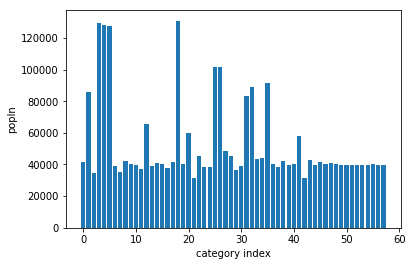

In [17]:
# new 
categories = new_df.Category
print(categories.unique())
print( len(categories.unique()) )
gen_barchart(categories)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
58


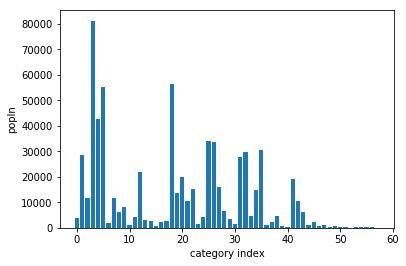

In [18]:
# orginal 
categories = df.Category
print( categories.unique() )
print( len(categories.unique()) )
gen_barchart(categories)

# Extract 'titles' from nonenglish.csv, to .txt file for free google translation

In [31]:
if recont_feature_const['extracttitles']['go_in']:
    curr_df = pd.read_csv(data_clean+"nonenglish.csv")

    # combine_str = curr_df['title'].str.cat(sep='/n')
    with open(data_secondary+'nonenglish_title.txt', 'w') as the_file:
        for row in curr_df['title']:
            the_file.write(row + '\n')
    
    

# After translation of non-english titles.
# Merge to translated_data then
# Merge to train_translated.csv 

In [104]:
if recont_feature_const['mergetranslatedtitle']['go_in']:
    nonenglish_translated = open( data_secondary+ "translated.txt").readlines()
    nonenglish_df = pd.read_csv(data_secondary+ "nonenglish.csv")
    english_df = pd.read_csv(data_secondary+ "english.csv")

    for i in range(0, len(nonenglish_translated)):
        nonenglish_translated[i] = nonenglish_translated[i].strip()
        

    nonenglish_translated = pd.DataFrame([i for i in nonenglish_translated], columns=['title'])
    
    nonenglish_df['title'] = nonenglish_translated

    print(nonenglish_df.shape)
    print(english_df.shape)
    
    train_translated['itemid'] = train_translated['itemid'].astype('int')
    train_translated.sort_values(by='itemid') # sort df based on itemid

    train_translated.to_csv(data_clean+'train_translated.csv', mode = 'w', index=False) 

(420435, 6)
(246180, 6)
